In [1]:
from BCM_lensing.halo import Halo
from BCM_lensing.component import CG, BG, EG, RDM
from BCM_lensing.utils import *
import numpy as np
import matplotlib.pyplot as plt
ffrom scipy.interpolate import interp1d
import warnings; warnings.simplefilter('ignore')

In [2]:
# Plot params
SMALL_SIZE = 12
L_SIZE     = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=L_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=L_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=L_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
M1 = 8.63e1
M_c = 3.3e3
beta = .12
eta=.54
omega_b=0.0486
omega_m=0.3089037

halo_num=110
particle_mass = 4.8e-2

# Put Path To Files Here

In [5]:
import pickle

In [24]:
infile = open('./Data/subhalo_dm', 'rb')     ## Use your own path
subhalo_dm   = pickle.load(infile)
infile.close()
infile = open('./Data/subhalo_dm_r', 'rb')   ## Use your own path
subhalo_dm_r   = pickle.load(infile)
infile.close()

# Building a halo

In [7]:
# Build a halo object
halo = Halo(subhalo_dm, subhalo_dm_r)

In [8]:
# You can choose the maximum r_value  as mult * r_200
mult = 100

# Also the resolution of the fittings/ number of radial shells
halo.resolution=20

halo.run_density(mult)

# Fit NFW parameters
halo.nfw_fit()

In [10]:
def plot_fit(hd, ri, popt, r_200, save=False):
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True, gridspec_kw={'hspace':.1, 'height_ratios':[3, 1]})
    ax1.loglog(ri/r_200, hd, '.', label='Data')
    ax1.loglog(ri/r_200, halo.nfw_density(ri, *popt, clipped=True), label='NFW_fit')
    ax2.semilogx(ri/r_200, hd/halo.nfw_density(ri, *popt, clipped=True), label='Error')
    ax1.legend(fontsize=(16))
    ax2.set_xlabel(r'$r/r_{200}$', fontsize=18)
    ax1.set_ylabel(r'$\dfrac{\log(\rho)}{\log(\rho_{c})}$', fontsize=18)
    ax2.set_ylabel(r'$\dfrac{\rho_{data}}{\rho_{NFW}}$', fontsize=18);
    plt.tight_layout()
        

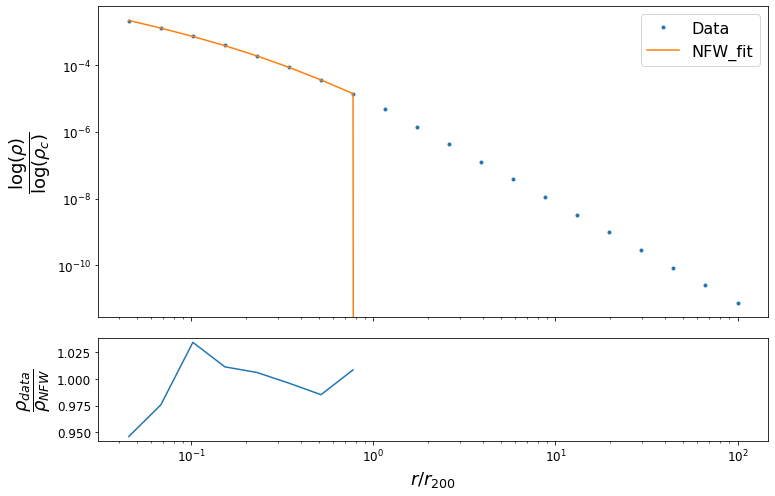

In [11]:
plot_fit(halo.halo_density, halo.ri, [halo.c, halo.rho_s], halo.r_200)

# Looking at corrections

## Density Functions

In [12]:
# We initialize each component using the halo quantities
cg = CG(halo.r_200, halo.m_200, halo.c, halo.rho_s)
bg = BG(halo.r_200, halo.m_200, halo.c, halo.rho_s)
eg = EG(halo.r_200, halo.m_200, halo.c, halo.rho_s)

# RDM is dependant on the previous three quantities
rdm = RDM(cg, bg, eg)

#Compute the xi factor
xi = rdm.run_xi(halo.ri, halo.masses)

# Compute the densities 
cg_d = cg.density(halo.ri)
bg_d = bg.density(halo.ri)
eg_d = eg.density(halo.ri)
rdm_d = rdm.density(halo.ri, halo.masses, xi)

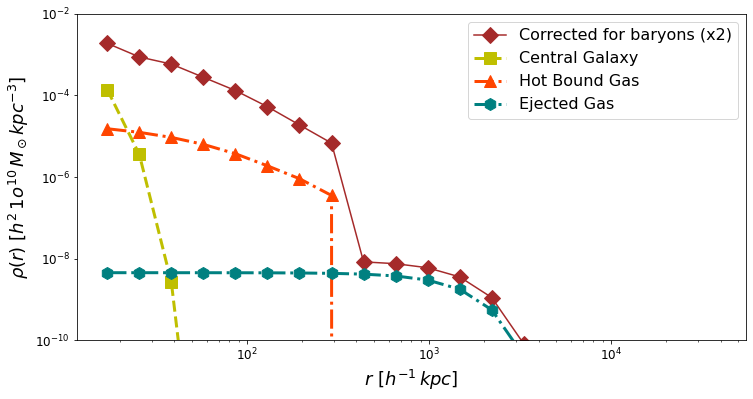

In [13]:
plt.figure(figsize=(12, 6))
plt.loglog(halo.ri, 2 * (rdm_d + cg_d + eg_d +bg_d), marker='D', c='brown', label='Corrected for baryons (x2)', markersize=12)
plt.loglog(halo.ri, cg_d, marker='s', color='y',  linestyle='--', linewidth=3, label='Central Galaxy', markersize=12)
plt.loglog(halo.ri, bg_d, marker='^', c='orangered',  linestyle='-.', linewidth=3, label='Hot Bound Gas', markersize=12)
plt.loglog(halo.ri, eg_d, marker='h', c='teal', linestyle='-.', linewidth=3, label='Ejected Gas', markersize=12)


plt.legend(fontsize=16)
plt.ylim(1e-10, 1e-2)
# plt.xlim(4e-2)
plt.xlabel(r'$r \,\,[h^{-1}\,kpc]$', fontsize=18)
plt.ylabel(r'$\rho(r)\,\, [h^{2}\,1o^{10}\,M_\odot kpc^{-3}]$', fontsize=18);

## Mass functions

In [14]:
# Easy Peesy Lemon Squeezy
cg_m = cg.Mass(halo.ri)
bg_m = bg.Mass(halo.ri)
eg_m = eg.Mass(halo.ri)
rdm_m = rdm.Mass(halo.ri, halo.masses, xi)

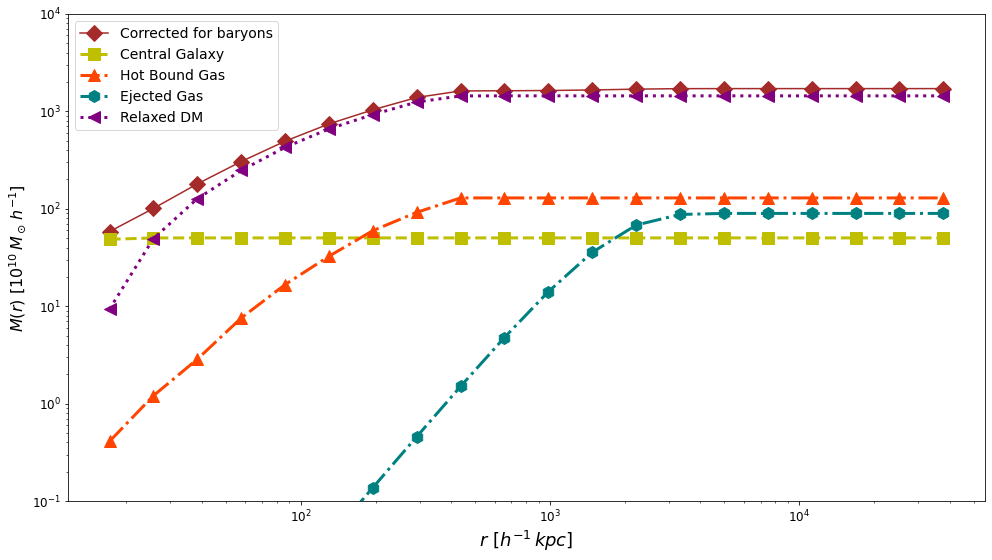

In [15]:
plt.figure(figsize=(14, 8))
plt.loglog(halo.ri, (cg_m+bg_m+eg_m+rdm_m), marker='D', c='brown', label='Corrected for baryons', markersize=12)
plt.loglog(halo.ri, cg_m, marker='s', color='y',  linestyle='--', linewidth=3, label='Central Galaxy', markersize=12)
plt.loglog(halo.ri, bg_m, marker='^', c='orangered',  linestyle='-.', linewidth=3, label='Hot Bound Gas', markersize=12)
plt.loglog(halo.ri, eg_m, marker='h', c='teal', linestyle='-.', linewidth=3, label='Ejected Gas', markersize=12)
plt.loglog(halo.ri, rdm_m,linestyle=':',lw=3,  marker='<', c='purple', label='Relaxed DM', markersize=12)


plt.legend()
plt.ylim(1e-1, 1e4)
# plt.xlim(4e-2, 10)
plt.xlabel(r'$r \,\,[h^{-1}\,kpc]$', fontsize=18)
plt.ylabel(r'$M(r)\,\, [10^{10}\,M_\odot\,h^{-1}]$');

plt.tight_layout()


# Putting it all together

In [17]:
# Build a halo object
# halo = Halo(halo_num, group_df, groupPos, subgroupPos, resolution=20)
halo = Halo(subhalo_dm, subhalo_dm_r)
halo.run_density(mult=10)

# Fit NFW parameters
halo.nfw_fit()

# Generate the BCM components
cg = CG(halo.r_200, halo.m_200, halo.c, halo.rho_s)
bg = BG(halo.r_200, halo.m_200, halo.c, halo.rho_s)
eg = EG(halo.r_200, halo.m_200, halo.c, halo.rho_s)
rdm = RDM(cg, bg, eg)

# Compute the relaxation parameter xi for each r
xi = rdm.run_xi(halo.ri, halo.masses)

# Calculate the BCM mass profile
M_BCM = cg.Mass(halo.ri) + bg.Mass(halo.ri) + eg.Mass(halo.ri) + rdm.Mass(halo.ri, halo.masses, xi)

# Convert particle positions in a subgroup to spherical coordinates
spherical = get_spherical(halo.subhalo_dm['Coordinates'], halo.sg_COM)
r = spherical[0, :]

# Remember the order of r
i = np.argsort(r)
r_sorted = r[i]

# Interpolate the BCM to each of the particle r's
M_BCM_interp = interp1d(halo.ri, M_BCM, fill_value='extrapolate')
M_BCM_total = M_BCM_interp(r_sorted)

# Compute the true mass profile
true_masses = (np.arange(len(r_sorted))+1) * particle_mass

# build_r interpolateion to get r(M)
r_interp = interp1d(true_masses, r_sorted, fill_value='extrapolate')

# Plug M_BCM into r(M) to get r_BCM
r_BCM = r_interp(M_BCM_total)

# Compute the difference in the radii
dr = r_sorted- r_BCM
dr[r_sorted>halo.r_200] = 0
dr[r_sorted<halo.ri[0]] = 0

# Return to original order
res = np.empty(dr.shape)
res[i] = dr

# Apply correction
spherical_new = spherical.copy()
spherical_new[0, :] = spherical[0, :] + res


# Convert back to cartesian 
new_cartesian = make_cartesian(spherical_new, halo.sg_COM)



In [18]:
phi_pos = dr.copy()
phi_neg = dr.copy()
phi_pos[dr<0] = 0
phi_neg[dr>0] = 0
phi_neg[dr<0] = np.abs(phi_neg[dr<0])

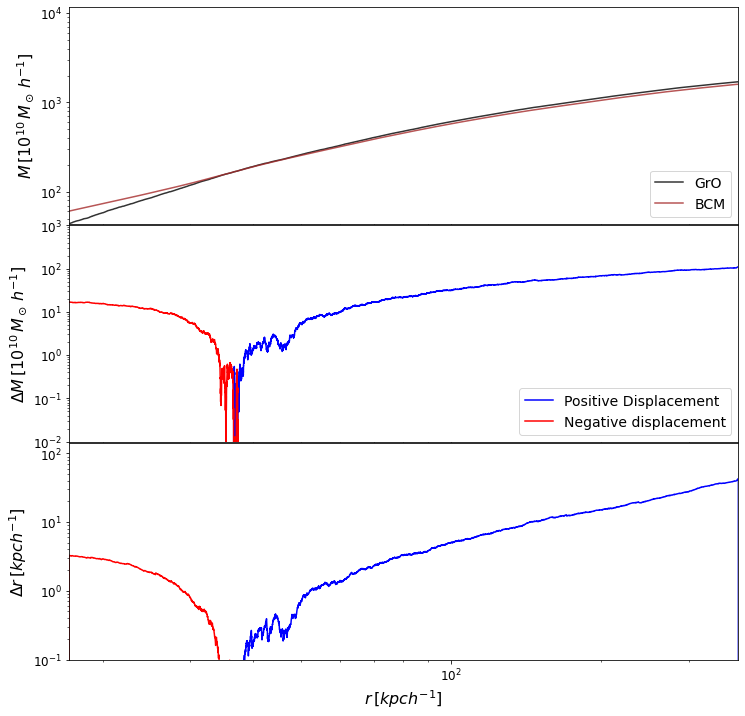

In [23]:
# PLOT CHECK

fig, axs = plt.subplots(nrows=3, figsize=(12, 12), sharex=True, gridspec_kw = {'hspace':.005})
r_sorted = np.array(r_sorted)
axs[0].loglog(r_sorted, true_masses, '-', markersize=.8, alpha=.8, c='k', label='GrO')
axs[0].loglog(r_sorted, M_BCM_total, '-', markersize=.8, alpha=.8, c='brown', label='BCM')
diff =true_masses - M_BCM_total
axs[1].loglog(r_sorted, diff, '-', c='blue', label='Positive Displacement')
diff[diff>0] = 0
diff[diff<0] = np.abs(diff[diff<0])
axs[1].loglog(r_sorted, diff, '-', c='red', label='Negative displacement')
axs[2].loglog(r_sorted, phi_neg, '-', c='red')
axs[2].loglog(r_sorted, phi_pos, '-', c='blue')



axs[0].set_ylabel(r'$M\,[10^{10}\,M_\odot\,h^{-1}]$')
axs[1].set_ylabel(r'$\Delta M\,[10^{10}\,M_\odot\,h^{-1}]$')
axs[2].set_ylabel(r'$\Delta r \, [kpc h^{-1}]$')
axs[2].set_xlabel(r'$r \, [kpc h^{-1}]$')

axs[0].legend(loc='lower right')
axs[1].legend(loc='lower right')







axs[0].set_xlim(halo.ri[0], halo.r_200)
axs[0].set_ylim(np.max(np.array(true_masses)[r_sorted<halo.ri[0]]), np.max(halo.masses)+10000)
axs[1].set_ylim(1e-2, np.max(diff)+1000)
axs[2].set_ylim(1e-1, np.max(phi_pos)+100)


plt.tight_layout()
